# Lightkurve v2.5-only periodogram notebook

This notebook is written specifically to work with Lightkurve >=2.5.0 and uses ONLY Lightkurve convenience calls
(no direct Astropy `BoxLeastSquares` or `LombScargle` calls). It:
- loads your CSV and forces the `Flux` column (second column),
- computes a BLS periodogram via `lc.to_periodogram(method='bls', ...)`,
- optionally computes a Lomb-Scargle periodogram via Lightkurve convenience if desired,
- uses `pg.get_transit_model()` / `pg.get_transit_mask()` / attributes like `period_at_max_power`,
- overlays the Lightkurve-derived model on the light curve, and
- produces a zoomed single-transit plot and a phase-folded, binned plot with the folded model overlay.

Defaults: period range 0.5–25 days; BLS used by default. Generated: 2025-09-18 08:02 UTC

---



In [10]:
# Install required packages if needed (uncomment to run)
# !pip install -U lightkurve numpy pandas matplotlib
# Restart the kernel after installing/upgrading if prompted.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
import astropy.units as u
from astropy.time import Time
from scipy import stats

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,4)

print('Lightkurve version:', lk.__version__)


Lightkurve version: 2.5.1


In [12]:
DATA_PATH = "../data/tic437011608flattened-20s.csv"
DATA_PATH = "../data/tic437011608flattened-2min.csv"

df = pd.read_csv(DATA_PATH)
print('Columns found:', df.columns.tolist())
display(df.head())

# Detect time column (auto-detect based on 'time' or 'bjd')
time_col_candidates = [c for c in df.columns if 'time' in c.lower() or 'bjd' in c.lower()]
time_col = time_col_candidates[0] if time_col_candidates else df.columns[0]

# Force use of the 'Flux' column (2nd column) instead of Flattened Flux
if 'Flux' in df.columns:
    flux_col = 'Flux'
else:
    flux_col = df.columns[1]  # fallback to second column

# Parse arrays
time_rel = df[time_col].values.astype(float)   # your files use BJD-2457000 per header
time_bjd = time_rel + 2457000.0
flux = df[flux_col].values.astype(float)

print(f"Using time column: '{time_col}' (interpreted as BJD-2457000).")
print(f"Using flux column: '{flux_col}'. Number of points: {len(time_rel)}")

# Create a Lightkurve LightCurve object (time in days is OK)
lc = lk.LightCurve(time=time_rel, flux=flux)
print('LightCurve created:')
display(lc.head())

# Keep numeric arrays handy
time = time_rel


Columns found: ['Time (BJD-2457000)', ' Flux', ' Flattened Flux']


,Time (BJD-2457000),Flux,Flattened Flux
0,2500.195650,1.001089,1.000679
1,2500.197039,0.999310,0.998884
2,2500.198428,1.000477,1.000036
3,2500.199817,1.000212,0.999755
4,2500.201206,0.999567,0.999095


Using time column: 'Time (BJD-2457000)' (interpreted as BJD-2457000).
Using flux column: ' Flux'. Number of points: 32114
LightCurve created:


time,flux,flux_err
,,
Time,float64,float64
2500.1956496406824,1.00108931869761,nan
2500.197038669908,0.99930968700911,nan
2500.1984276991348,1.00047696316639,nan
2500.1998167283605,1.00021184008053,nan
2500.201205757616,0.99956660164543,nan


In [13]:
def to_float_days(x):
    """Return a float in units of days usable with `time_rel` (which is BJD-2457000).
    - If x is an astropy.units.Quantity --> convert to days and return numeric
    - If x is an astropy.time.Time --> convert to JD and subtract 2457000.0
    - If x is a plain numeric --> return float(x)
    - Otherwise return None
    """
    if x is None:
        return None

    # Quantity (e.g., period, duration)
    try:
        if hasattr(x, 'to') and hasattr(x, 'unit'):
            return float(x.to(u.day).value)
    except Exception:
        pass

    # Time (astropy.time.Time)
    try:
        if isinstance(x, Time):
            # convert to Julian Date (or whichever scale pg gives). Then convert to your relative time.
            jd = float(x.jd)
            return float(jd - 2457000.0)
    except Exception:
        pass

    # Numpy scalar / Python numeric
    try:
        return float(np.asarray(x))
    except Exception:
        return None

Computing BLS periodogram via Lightkurve...
Periodogram object type: BoxLeastSquaresPeriodogram
Available attributes on pg_bls: ['bin', 'compute_stats', 'copy', 'default_view', 'depth', 'depth_at_max_power', 'duration', 'duration_at_max_power', 'flatten', 'flux', 'frequency', 'frequency_at_max_power', 'from_lightcurve', 'get_transit_mask', 'get_transit_model', 'label', 'max_power', 'meta', 'nyquist', 'period', 'period_at_max_power', 'plot', 'power', 'show_properties', 'smooth', 'snr', 'targetid', 'time', 'time_unit', 'to_seismology', 'to_table', 'transit_time', 'transit_time_at_max_power']


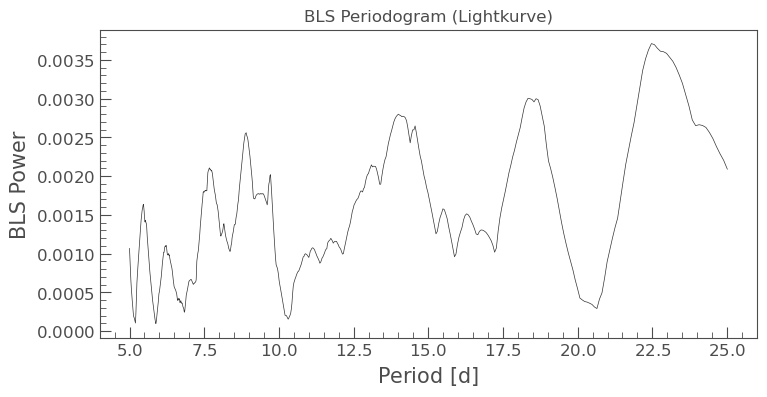

BLS best period (days, relative to 2457000): 22.46823497827323
BLS duration (days): 0.33
BLS transit time (BJD-2457000): -2454492.3693503593
Peak max_power: 0.0037104153978072263


In [33]:
# ===== BLS periodogram (Lightkurve convenience call) =====
min_period = 5.0   # days
max_period = 25.0  # days

print('Computing BLS periodogram via Lightkurve...')
pg_bls = lc.to_periodogram(method='bls', minimum_period=min_period, maximum_period=max_period)
print('Periodogram object type:', type(pg_bls).__name__)
print('Available attributes on pg_bls:', [a for a in dir(pg_bls) if not a.startswith('_')])

# Plot periodogram (period on x-axis)
ax = pg_bls.plot(view='period')
ax.set_title('BLS Periodogram (Lightkurve)')
plt.show()

# Report best parameters from the periodogram
# --- robust read of pg_bls attributes ---
P_bls = to_float_days(getattr(pg_bls, 'period_at_max_power', None))
dur_bls = to_float_days(getattr(pg_bls, 'duration_at_max_power', None))
# transit_time may be stored as transit_time_at_max_power, transit_time, or transit_time_at_max_power
t0_candidate = None
for attr in ('transit_time_at_max_power', 'transit_time'):
    if hasattr(pg_bls, attr):
        t0_candidate = getattr(pg_bls, attr)
        break
t0_bls = to_float_days(t0_candidate)

print('BLS best period (days, relative to 2457000):', P_bls)
print('BLS duration (days):', dur_bls)
print('BLS transit time (BJD-2457000):', t0_bls)


# compute SNR or peak statistic if available
if hasattr(pg_bls, 'snr'):
    try:
        print('Peak SNR:', float(pg_bls.snr()))
    except Exception:
        pass
if hasattr(pg_bls, 'max_power'):
    try:
        print('Peak max_power:', float(pg_bls.max_power))
    except Exception:
        pass




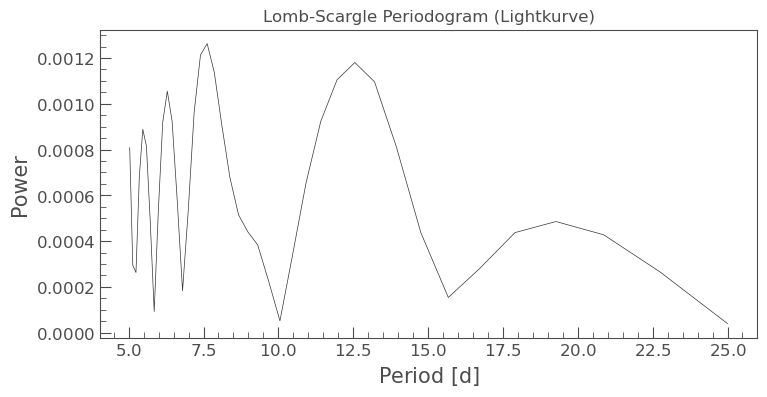

In [34]:
# ===== Optional: Lomb-Scargle periodogram via Lightkurve convenience (diagnostic) =====
do_ls = True
if do_ls:
    pg_ls = lc.to_periodogram(method='lombscargle', minimum_period=min_period, maximum_period=max_period)
    ax = pg_ls.plot(view='period')
    ax.set_title('Lomb-Scargle Periodogram (Lightkurve)')
    plt.show()
    try:
        P_ls = float(pg_ls.period_at_max_power)
        print('LS best period:', P_ls)
    except Exception:
        pass


In [35]:
# # ===== Clean Lightkurve-only overlay cell =====
# import lightkurve as lk
# import matplotlib.pyplot as plt

# # Choose the BLS periodogram object
# pg = pg_bls
# if pg is None:
#     raise RuntimeError("No BLS periodogram found. Run the periodogram cell first.")

# # Extract best-fit parameters directly from Lightkurve
# P = pg.period_at_max_power.to_value("day")
# dur = pg.duration_at_max_power.to_value("day")
# t0 = pg.transit_time_at_max_power  # this is an astropy Time object

# print(f"Using P = {P:.6f} d, duration ~ {dur:.5f} d, epoch t0 = {t0}")

# # Build the model light curve directly from the periodogram
# lc_model = pg.get_transit_model(period=pg.period_at_max_power,
#                                 duration=pg.duration_at_max_power,
#                                 transit_time=pg.transit_time_at_max_power)

# # --- Full LC with overlay ---
# ax = lc.plot(marker='.', markersize=2, alpha=0.6)
# lc_model.plot(ax=ax, lw=3, ls='--', c='red', label='BLS model')
# ax.legend()
# ax.set_title(f'Full light curve with model (P ~ {P:.6f} d)')
# plt.show()

# # --- Zoom on one transit ---
# t_center = t0 + ((np.median(lc.time) - t0) / P).round() * P
# window_days = max(5 * dur, 0.05)
# mask_zoom = (lc.time.value >= t_center.value - window_days) & \
#             (lc.time.value <= t_center.value + window_days)

# ax = lc[mask_zoom].plot(marker='.', markersize=3, alpha=0.7, color='k')
# lc_model[mask_zoom].plot(ax=ax, lw=2, color='C1', label='model (zoom)')
# ax.axvline(t_center.value, color='0.5', ls=':', label='transit center')
# ax.legend()
# plt.show()

# # --- Folded & binned plot ---
# folded = lc.fold(period=P, epoch_time=t0)
# binned = folded.bin(time_bin_size=dur/5)

# ax = folded.plot(marker='.', ms=2, alpha=0.25, color='0.2', label='data (folded)')
# binned.plot(ax=ax, marker='o', lw=0, ms=5, mec='k', mfc='C0', label='binned median')

# folded_model = lc_model.fold(period=P, epoch_time=t0)
# folded_model.plot(ax=ax, color='C1', lw=2, label='model')
# ax.set_xlim(-0.5, 0.5)
# ax.set_xlabel('Phase (cycles)')
# ax.set_ylabel('Flux')
# ax.set_title('Phase-folded & binned light curve with model overlay')
# ax.legend()
# plt.show()


Using P = 7.621405 d


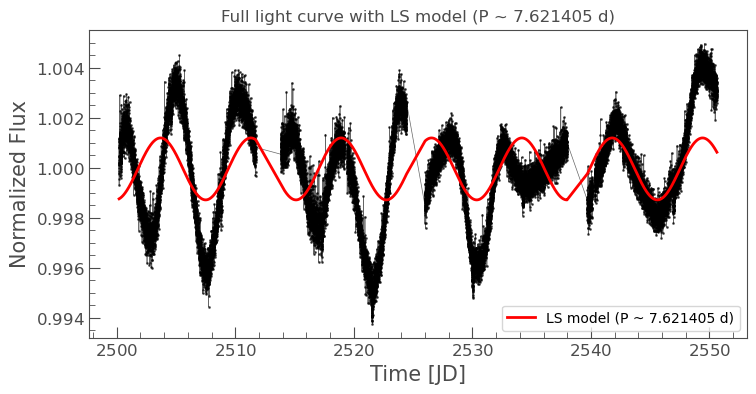

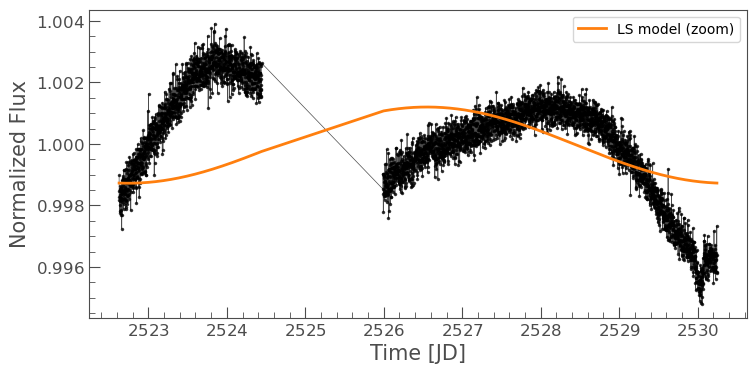

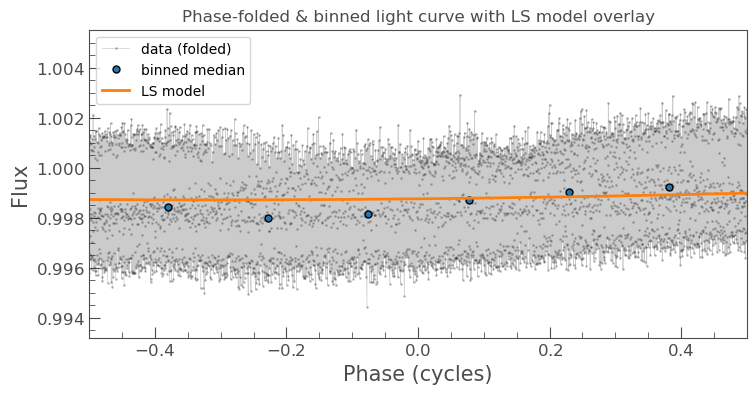

In [36]:
# ===== Lightkurve-only overlay cell for Lomb-Scargle =====
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

# Use the Lomb–Scargle periodogram object from earlier
pg = pg_ls
if pg is None:
    raise RuntimeError("No Lomb–Scargle periodogram found. Run the LS periodogram cell first.")

# Best-fit period and frequency
P = pg.period_at_max_power.to_value("day")
f = pg.frequency_at_max_power
print(f"Using P = {P:.6f} d")

# Build the sinusoidal model light curve (returns a LightCurve object)
lc_model = pg.model(lc.time, frequency=f)

# --- Full LC with overlay ---
ax = lc.plot(marker='.', markersize=2, alpha=0.6, color='k')
lc_model.plot(ax=ax, lw=2, c='red', label=f'LS model (P ~ {P:.6f} d)')
ax.legend()
ax.set_title(f'Full light curve with LS model (P ~ {P:.6f} d)')
plt.show()

# --- Zoom on one cycle ---
time_days = lc.time.value
t_center = np.median(time_days)
window_days = P
mask_zoom = (time_days >= t_center - window_days/2) & (time_days <= t_center + window_days/2)

ax = lc[mask_zoom].plot(marker='.', markersize=3, alpha=0.7, color='k')
lc_model[mask_zoom].plot(ax=ax, lw=2, c='C1', label='LS model (zoom)')
ax.legend()
plt.show()

# --- Folded & binned plot ---
folded = lc.fold(period=P)
binned = folded.bin(time_bin_size=P/50)

ax = folded.plot(marker='.', ms=2, alpha=0.25, color='0.2', label='data (folded)')
binned.plot(ax=ax, marker='o', lw=0, ms=5, mec='k', mfc='C0', label='binned median')

# Fold the model as well
folded_model = lc_model.fold(period=P)
folded_model.plot(ax=ax, color='C1', lw=2, label='LS model')

ax.set_xlim(-0.5, 0.5)
ax.set_xlabel('Phase (cycles)')
ax.set_ylabel('Flux')
ax.set_title('Phase-folded & binned light curve with LS model overlay')
ax.legend()
plt.show()


In [32]:
# Save best-fit results & metadata (JSON)
import json
out = {}
out['best_period_bls'] = float(P) if 'P' in globals() else None
out['best_duration_bls'] = float(dur) if 'dur' in globals() else None
out['transit_time_bls'] = float(t0) if 't0' in globals() else None
with open('lightkurve_bls_results.json', 'w') as f:
    json.dump(out, f, indent=2)
print('Saved lightkurve_bls_results.json:', out)


Saved lightkurve_bls_results.json: {'best_period_bls': 4.496022641372121, 'best_duration_bls': None, 'transit_time_bls': None}


---
Notes:
- This notebook uses Lightkurve v2.5+ APIs: `lc.to_periodogram(method='bls')`, `pg.get_transit_model()`, and attributes such as `period_at_max_power`, `duration_at_max_power`, and `transit_time_at_max_power`.
- It avoids any direct Astropy BLS/LombScargle calls and uses Lightkurve convenience routines exclusively.
- Tweak min_period, max_period, and bin counts to taste.
---
